In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import sys
import warnings
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from failure_detector import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
dl = DataLoader()
dl.load('sample.log')
dl.extractinfo(export=True,single_file=True)

mongodb://localhost:27017/
Database connected


In [74]:
def cat_to_int(df,col):
    try:
        df[col]  = pd.factorize(df[col])[0]
    except:
        print('Error Occured while casting')
        
def corr_var(filename,dictlist):
    """
    :param dictlist  : dict with components needed as key and variable list as values 
    e.g. { RCIN : [C1,C2 ..]}
    """
    full_df = pd.DataFrame({'tempcol':[0]}) #temp dataframe
    
    for key,values in dictlist.items():
        df = pd.DataFrame(dl.dbconnector.query(key+'_'+filename))
        try:
            #choose only the columns that exists in dataframe
            values = list(set(df.columns) & set(values))
            df = df[values+['lineIndex']].set_index('lineIndex')
            df.columns = [key+'_'+col for col in df.columns]
        except:
            print('Columns not found..')
            continue
        full_df = pd.concat([full_df,df],axis =1).fillna(method = 'ffill')
    full_df = full_df.drop([0],axis=0)
    full_df = full_df.drop('tempcol',axis=1)
    #check for categorical columns and set them for numeric
    for col in full_df.columns:
        if not full_df[col].dtype.kind in 'bifc':
            cat_to_int(full_df,col)
    return full_df,full_df.corr()

# Sample Log Analysis

In [15]:
ts = {'RCIN':['C1','C2','C3','C4'] ,'AHR2':['Roll','Pitch','Alt','Yaw']}
df,df_corr = corr_var('sample.log',ts)
df_corr.iloc[4:,:4]

,RCIN_C1,RCIN_C2,RCIN_C3,RCIN_C4
AHR2_Roll,0.841028,-0.018129,-0.030206,0.501776
AHR2_Pitch,0.061377,0.631013,-0.227663,0.202982
AHR2_Alt,-0.009509,-0.010000,0.303141,-0.105879
AHR2_Yaw,0.060121,-0.003648,0.058846,-0.111098


In [16]:
ts = {'MODE':['Mode'] ,'ERR':['Subsys']}
df,df_corr = corr_var('sample.log',ts)
df_corr

,MODE_Mode,ERR_Subsys
MODE_Mode,1.000000,-0.522233
ERR_Subsys,-0.522233,1.000000


# All Logs - Mean Correlation - RCIN : AHR2

In [17]:
datalist =os.listdir('../data')

In [18]:
ts = {'RCIN':['C1','C2','C3','C4'] ,'AHR2':['Roll','Pitch','Alt','Yaw']}
print('File:{} --  {} / {}'.format(datalist[0],0,len(datalist)-1))
d,df_cnc = corr_var(datalist[0][:-4],ts)
df_cnc = df_cnc.iloc[4:,:4]
for i,log in enumerate(datalist[1:]):
    print('File:{} --  {} / {}'.format(log,i+1,len(datalist)-1))
    _,df_corr = corr_var(log[:-4],ts)
    df_cnc = pd.concat((df_cnc, df_corr.iloc[4:,:4]))

#compute the Mean 
by_row_index = df_cnc.groupby(df_cnc.index)
df_means = by_row_index.mean()
df_means

File:568c058bb560505c22dc402c.log --  0 / 2607
File:568c0b3a7132fa902e401d31.log --  1 / 2607
File:568c0db17132fa902e401d33.log --  2 / 2607
File:568c0e8f7132fa902e401d34.log --  3 / 2607
File:568c0f4a7132fa902e401d35.log --  4 / 2607
Columns not found..
Columns not found..
File:56d75dd746a12d150ba9724f.log --  5 / 2607
File:56d7e5a546a12d150ba97250.log --  6 / 2607
File:56f69d8d85e739af3b3cb422.log --  7 / 2607
File:56f6af5385e739af3b3cb424.log --  8 / 2607
Columns not found..
File:56f6af5b85e739af3b3cb425.log --  9 / 2607
Columns not found..
File:56f6af6885e739af3b3cb426.log --  10 / 2607
Columns not found..
File:56f6af7385e739af3b3cb427.log --  11 / 2607
Columns not found..
File:5757cf85cf913b9b04694227.log --  12 / 2607
Columns not found..
Columns not found..
File:5757d3dfcf913b9b04694228.log --  13 / 2607
Columns not found..
Columns not found..
File:5757d47fcf913b9b04694229.log --  14 / 2607
Columns not found..
Columns not found..
File:575ce9d988bc9002549dfb5e.log --  15 / 2607
Co

File:576802cf8cd19b1211422629.log --  112 / 2607
Columns not found..
Columns not found..
File:576805fc8cd19b121142262a.log --  113 / 2607
Columns not found..
Columns not found..
File:576814e6b417477362f300f1.log --  114 / 2607
Columns not found..
Columns not found..
File:576824d972ee277c7e5a243f.log --  115 / 2607
Columns not found..
Columns not found..
File:5768261072ee277c7e5a2440.log --  116 / 2607
Columns not found..
Columns not found..
File:5768265172ee277c7e5a2441.log --  117 / 2607
Columns not found..
Columns not found..
File:576826af72ee277c7e5a2442.log --  118 / 2607
Columns not found..
Columns not found..
File:57682fc072ee277c7e5a2447.log --  119 / 2607
Columns not found..
Columns not found..
File:5768334072ee277c7e5a244c.log --  120 / 2607
Columns not found..
Columns not found..
File:5768352272ee277c7e5a244d.log --  121 / 2607
Columns not found..
File:576835cb72ee277c7e5a244e.log --  122 / 2607
Columns not found..
File:5768403c72ee277c7e5a244f.log --  123 / 2607
Columns not 

File:5779228a7d47cdc358ac67ea.log --  220 / 2607
Columns not found..
Columns not found..
File:577922a57d47cdc358ac67eb.log --  221 / 2607
File:5779230f7d47cdc358ac67ec.log --  222 / 2607
File:5779243e7d47cdc358ac67ed.log --  223 / 2607
Columns not found..
Columns not found..
File:57792c897d47cdc358ac67f0.log --  224 / 2607
Columns not found..
Columns not found..
File:577939aa7d47cdc358ac67f4.log --  225 / 2607
Columns not found..
File:577952717d47cdc358ac67fa.log --  226 / 2607
File:577966698bbe3d955cae61fb.log --  227 / 2607
Columns not found..
Columns not found..
File:577969258bbe3d955cae61fc.log --  228 / 2607
Columns not found..
File:57796b478bbe3d955cae61fd.log --  229 / 2607
Columns not found..
File:57796ca58bbe3d955cae61fe.log --  230 / 2607
Columns not found..
File:5779874c8bbe3d955cae6200.log --  231 / 2607
Columns not found..
File:577990648bbe3d955cae6201.log --  232 / 2607
Columns not found..
File:5779906c8bbe3d955cae6202.log --  233 / 2607
Columns not found..
File:5779906f8

Columns not found..
Columns not found..
File:578a8b0c70d64c2d0cb0b78f.log --  342 / 2607
File:578b1f312774d3b31bd2dbd5.log --  343 / 2607
Columns not found..
Columns not found..
File:578b1f942774d3b31bd2dbd6.log --  344 / 2607
Columns not found..
Columns not found..
File:578b1ffb2774d3b31bd2dbd7.log --  345 / 2607
Columns not found..
Columns not found..
File:578b67b1dec68d064b1400cb.log --  346 / 2607
Columns not found..
Columns not found..
File:578ba512b5c94d575e867259.log --  347 / 2607
Columns not found..
File:578bcbcea56e1343709df030.log --  348 / 2607
Columns not found..
Columns not found..
File:578bcf10a56e1343709df032.log --  349 / 2607
Columns not found..
Columns not found..
File:578bcf9ca56e1343709df033.log --  350 / 2607
Columns not found..
Columns not found..
File:578bd0dfa56e1343709df034.log --  351 / 2607
Columns not found..
Columns not found..
File:578c4e28e6f0ee8f5b5e3a84.log --  352 / 2607
Columns not found..
Columns not found..
File:578ca61aa023a7f75c683e49.log --  353

Columns not found..
Columns not found..
File:579e26be1d4122571f97184c.log --  466 / 2607
Columns not found..
Columns not found..
File:579e279f1d4122571f97184d.log --  467 / 2607
Columns not found..
Columns not found..
File:579e2f621d4122571f97184e.log --  468 / 2607
Columns not found..
File:579e30171d4122571f97184f.log --  469 / 2607
Columns not found..
File:579e318f1d4122571f971850.log --  470 / 2607
Columns not found..
Columns not found..
File:579e329d1d4122571f971851.log --  471 / 2607
Columns not found..
Columns not found..
File:579e33811d4122571f971853.log --  472 / 2607
Columns not found..
Columns not found..
File:579e366a1d4122571f971854.log --  473 / 2607
File:579e380fc19463a7335e32af.log --  474 / 2607
File:579e54e8c19463a7335e32b0.log --  475 / 2607
Columns not found..
File:579eee07c19463a7335e32b2.log --  476 / 2607
Columns not found..
Columns not found..
File:579f1884c19463a7335e32b3.log --  477 / 2607
File:579f18f5c19463a7335e32b4.log --  478 / 2607
File:579f4ddcd233ae3b49

File:57b03c40019164a07d19c9de.log --  582 / 2607
File:57b03c53019164a07d19c9df.log --  583 / 2607
File:57b03c54019164a07d19c9e0.log --  584 / 2607
File:57b08359019164a07d19c9e2.log --  585 / 2607
Columns not found..
Columns not found..
File:57b0aeec159701831322946c.log --  586 / 2607
Columns not found..
Columns not found..
File:57b0f0b3159701831322946d.log --  587 / 2607
File:57b223bf28c7742b2498b79e.log --  588 / 2607
Columns not found..
Columns not found..
File:57b2253428c7742b2498b79f.log --  589 / 2607
Columns not found..
Columns not found..
File:57b31cfbafda2ea36de2cca8.log --  590 / 2607
Columns not found..
Columns not found..
File:57b32322afda2ea36de2cca9.log --  591 / 2607
Columns not found..
Columns not found..
File:57b324cdafda2ea36de2ccab.log --  592 / 2607
Columns not found..
Columns not found..
File:57b32535afda2ea36de2ccac.log --  593 / 2607
Columns not found..
Columns not found..
File:57b34fe9afda2ea36de2ccaf.log --  594 / 2607
Columns not found..
Columns not found..
Fil

File:57c71096a1a220a4396ce1fc.log --  694 / 2607
File:57c8442a8d59a68721e71479.log --  695 / 2607
Columns not found..
Columns not found..
File:57c85834771999f507e21847.log --  696 / 2607
Columns not found..
Columns not found..
File:57c979287c8ab4cf257a4913.log --  697 / 2607
Columns not found..
Columns not found..
File:57c9cb246f56b50b369b8379.log --  698 / 2607
Columns not found..
File:57ca39b26f56b50b369b837a.log --  699 / 2607
Columns not found..
File:57ca866498159ab7272de19c.log --  700 / 2607
Columns not found..
Columns not found..
File:57ca8a5598159ab7272de19e.log --  701 / 2607
Columns not found..
Columns not found..
File:57ca8ab998159ab7272de1a0.log --  702 / 2607
Columns not found..
Columns not found..
File:57cacad298159ab7272de1a2.log --  703 / 2607
Columns not found..
Columns not found..
File:57cad34ef5c11b6511b87244.log --  704 / 2607
Columns not found..
File:57cadce6f5c11b6511b87245.log --  705 / 2607
Columns not found..
Columns not found..
File:57caeafb8fa7e9d2471b0a45.lo

Columns not found..
File:57e5ca9c91cf9db71b6940ff.log --  800 / 2607
Columns not found..
File:57e5cabd91cf9db71b694100.log --  801 / 2607
Columns not found..
File:57e5caf791cf9db71b694102.log --  802 / 2607
Columns not found..
File:57e5cdaab019454049c9fe67.log --  803 / 2607
Columns not found..
File:57e5f51cb019454049c9fe68.log --  804 / 2607
Columns not found..
File:57e622f9d6688c5553e07876.log --  805 / 2607
Columns not found..
File:57e66a24e26124771d2e1115.log --  806 / 2607
Columns not found..
File:57e6a705fe2146bb3f5788eb.log --  807 / 2607
File:57e6bed4fe2146bb3f5788ec.log --  808 / 2607
File:57e6bfdafe2146bb3f5788ed.log --  809 / 2607
File:57e6d14afe2146bb3f5788ee.log --  810 / 2607
Columns not found..
Columns not found..
File:57e6d1956affc08006ed82f7.log --  811 / 2607
Columns not found..
Columns not found..
File:57e7a1cfa500c2bd1b711692.log --  812 / 2607
Columns not found..
Columns not found..
File:57e7ae3535479a531fc16f0a.log --  813 / 2607
Columns not found..
Columns not fo

File:58033be7012e3a5945bbd0c3.log --  922 / 2607
Columns not found..
File:5803698c1962b6cf453e9c51.log --  923 / 2607
Columns not found..
File:58036a351962b6cf453e9c53.log --  924 / 2607
Columns not found..
File:580379e501b3f77b1f625ef2.log --  925 / 2607
Columns not found..
Columns not found..
File:5803c19c17c8c10048303d58.log --  926 / 2607
Columns not found..
Columns not found..
File:5803c2964109875a03a7a561.log --  927 / 2607
Columns not found..
Columns not found..
File:5803c39e4109875a03a7a562.log --  928 / 2607
Columns not found..
Columns not found..
File:5804bedd1990037b28f37c21.log --  929 / 2607
Columns not found..
Columns not found..
File:5804fa6732c5d91e1ca66ac9.log --  930 / 2607
File:58052e0d0044455179730a35.log --  931 / 2607
File:58064c36c477bf0c72fb40fe.log --  932 / 2607
File:580654a1c477bf0c72fb40ff.log --  933 / 2607
File:580681a87b48be86369bafb5.log --  934 / 2607
File:580694bfe60da0d7497ef369.log --  935 / 2607
File:5808ee716056864551549742.log --  936 / 2607
Colum

File:582cc635493c7b867b63265b.log --  1054 / 2607
File:582cc6b1493c7b867b63265c.log --  1055 / 2607
File:582cc732493c7b867b63265d.log --  1056 / 2607
File:582d4fd4d39aaef26d66dc6e.log --  1057 / 2607
File:582df01f809c4d200c45c2a7.log --  1058 / 2607
Columns not found..
Columns not found..
File:582e1c8fe305b1603e8ea2ae.log --  1059 / 2607
File:582eb8df1d07372013a951c5.log --  1060 / 2607
Columns not found..
Columns not found..
File:582eeda51d07372013a951c6.log --  1061 / 2607
Columns not found..
Columns not found..
File:582ef18f1d07372013a951c7.log --  1062 / 2607
Columns not found..
Columns not found..
File:582ef7b21d07372013a951c8.log --  1063 / 2607
Columns not found..
Columns not found..
File:582efb011d07372013a951c9.log --  1064 / 2607
File:582efc1d1d07372013a951ca.log --  1065 / 2607
File:582f683594d7c6e0263c430d.log --  1066 / 2607
File:582f7f1ea86ca76f4f92a2f3.log --  1067 / 2607
File:583034626c6fcfbd4cc061e2.log --  1068 / 2607
Columns not found..
Columns not found..
File:58305

File:58692e82382601a1241366b5.log --  1169 / 2607
Columns not found..
File:586a4eebe5dccbe54bcab625.log --  1170 / 2607
Columns not found..
Columns not found..
File:586a5654e5dccbe54bcab626.log --  1171 / 2607
Columns not found..
Columns not found..
File:586ab1e55727e2443c18d3c8.log --  1172 / 2607
Columns not found..
Columns not found..
File:586c2508466c3ab75de6f183.log --  1173 / 2607
File:586cc9d239682c1d13aa3f8e.log --  1174 / 2607
Columns not found..
Columns not found..
File:586cc9ec39682c1d13aa3f8f.log --  1175 / 2607
Columns not found..
Columns not found..
File:586cfbe945e9d5d762d53a8e.log --  1176 / 2607
Columns not found..
Columns not found..
File:586e371fa6efadd60e1b113e.log --  1177 / 2607
Columns not found..
Columns not found..
File:586f619dba4e9a7369b5ccce.log --  1178 / 2607
Columns not found..
Columns not found..
File:586f92e8f0aba3733457324f.log --  1179 / 2607
Columns not found..
File:58714a6075a7d9544e52684d.log --  1180 / 2607
Columns not found..
Columns not found..


File:58ac1e65de6f9a9225bd4592.log --  1283 / 2607
File:58ac97d0ded747ae57d25395.log --  1284 / 2607
File:58ac981ae1c906425cf96369.log --  1285 / 2607
File:58ac9e113a68f9be71bc8a03.log --  1286 / 2607
File:58ac9fbc3d7a5cf27a311653.log --  1287 / 2607
Columns not found..
Columns not found..
File:58aea0404457583a07d3c69b.log --  1288 / 2607
Columns not found..
Columns not found..
File:58aed47ae4e915ec5e2801f3.log --  1289 / 2607
Columns not found..
Columns not found..
File:58b00a0d8c6b5b026bcda136.log --  1290 / 2607
Columns not found..
File:58b3193ce7c3e8b52769d698.log --  1291 / 2607
File:58b412a9944cea2f36aa8bef.log --  1292 / 2607
File:58b54a307f1f319c42a8c2c9.log --  1293 / 2607
Columns not found..
Columns not found..
File:58b54a767f1f319c42a8c2ca.log --  1294 / 2607
Columns not found..
Columns not found..
File:58b6eff722451b141babff59.log --  1295 / 2607
Columns not found..
File:58b6f3ee6b3db11d36e77982.log --  1296 / 2607
Columns not found..
File:58b6f452ae9035f03a9f537d.log --  12

Columns not found..
File:58d6e7ee05cdfe636ac0884f.log --  1399 / 2607
Columns not found..
File:58d7871ba93f32d104d22799.log --  1400 / 2607
Columns not found..
Columns not found..
File:58d78c07a93f32d104d2279a.log --  1401 / 2607
Columns not found..
Columns not found..
File:58d7cbe08b04a54c1829fe2d.log --  1402 / 2607
Columns not found..
Columns not found..
File:58d7efe1ba1653da0ae5a9c3.log --  1403 / 2607
Columns not found..
Columns not found..
File:58d81b36c100ce7d5db4f402.log --  1404 / 2607
Columns not found..
Columns not found..
File:58d81b5dc100ce7d5db4f403.log --  1405 / 2607
Columns not found..
File:58d822816f16a6457678da84.log --  1406 / 2607
Columns not found..
File:58d91ddc5a2699946f68b03e.log --  1407 / 2607
File:58d9360da8b821c855d1d2f7.log --  1408 / 2607
Columns not found..
Columns not found..
File:58d983087de050a00d37d044.log --  1409 / 2607
File:58d9844a7de050a00d37d045.log --  1410 / 2607
File:58d984c67de050a00d37d046.log --  1411 / 2607
File:58d99e03e88df74574302683.

File:58fdebe73eb8dc015649d892.log --  1524 / 2607
Columns not found..
Columns not found..
File:58fdec563eb8dc015649d893.log --  1525 / 2607
Columns not found..
Columns not found..
File:58fe38daba797985178036e2.log --  1526 / 2607
File:58fe51ad93075ee84d66238e.log --  1527 / 2607
Columns not found..
File:58fe6184b0d9f3517f5b6854.log --  1528 / 2607
Columns not found..
File:58feee866b8d45326db551f2.log --  1529 / 2607
Columns not found..
Columns not found..
File:58feeec6f40999ac70709cc6.log --  1530 / 2607
Columns not found..
Columns not found..
File:58ff09af8a50e25b1624a1b3.log --  1531 / 2607
Columns not found..
File:58ff48260f0cb889479bb914.log --  1532 / 2607
Columns not found..
File:58ff66180f0cb889479bb915.log --  1533 / 2607
Columns not found..
File:58ff74757e6243073ad1e8a6.log --  1534 / 2607
Columns not found..
Columns not found..
File:58ff759d7e6243073ad1e8a7.log --  1535 / 2607
Columns not found..
Columns not found..
File:58ff76577e6243073ad1e8aa.log --  1536 / 2607
Columns no

File:59120ca6273fdd76234fe70e.log --  1639 / 2607
File:5912288b2ca81cbb4948e373.log --  1640 / 2607
Columns not found..
File:59122a1adedf30c071172e31.log --  1641 / 2607
File:59122a56dedf30c071172e32.log --  1642 / 2607
File:59122ae2dedf30c071172e33.log --  1643 / 2607
File:59122b10dedf30c071172e34.log --  1644 / 2607
Columns not found..
File:59122b17dedf30c071172e35.log --  1645 / 2607
File:59122b300fad0806760f2b0c.log --  1646 / 2607
File:59122ba543deda0d77f5f2d3.log --  1647 / 2607
Columns not found..
File:59122c1343deda0d77f5f2d4.log --  1648 / 2607
Columns not found..
File:59122c6043deda0d77f5f2d5.log --  1649 / 2607
File:59122c9743deda0d77f5f2d6.log --  1650 / 2607
Columns not found..
File:59122cd043deda0d77f5f2d7.log --  1651 / 2607
File:59122ce443deda0d77f5f2d8.log --  1652 / 2607
Columns not found..
File:59122d6d43deda0d77f5f2d9.log --  1653 / 2607
Columns not found..
File:59122f6643deda0d77f5f2da.log --  1654 / 2607
File:591244ff34847e1d2db19127.log --  1655 / 2607
Columns no

File:591c72c83fb9f60a3ecf4c5d.log --  1763 / 2607
Columns not found..
File:591c9d51baadbab635c3d9b2.log --  1764 / 2607
Columns not found..
File:591ca85a8b7c961c54b926b8.log --  1765 / 2607
File:591caac08b7c961c54b926b9.log --  1766 / 2607
File:591cbceb6af91f2978d52d9f.log --  1767 / 2607
File:591cbd326af91f2978d52da0.log --  1768 / 2607
File:591d2a050c535eeb216418ee.log --  1769 / 2607
Columns not found..
Columns not found..
File:591d46c1813350ae749fe553.log --  1770 / 2607
File:591d97a5a666a28b50f10da8.log --  1771 / 2607
Columns not found..
File:591d9fa56c39db2260e3d4b0.log --  1772 / 2607
Columns not found..
File:591da0026c39db2260e3d4b1.log --  1773 / 2607
Columns not found..
File:591dabb6ef04f84974d9a552.log --  1774 / 2607
Columns not found..
Columns not found..
File:591dbce6a15b4a8e19e635d3.log --  1775 / 2607
Columns not found..
Columns not found..
File:591de2c4f372186817cc67e1.log --  1776 / 2607
Columns not found..
File:591de468f372186817cc67e2.log --  1777 / 2607
Columns no

File:5935166abc78a05d03030496.log --  1885 / 2607
Columns not found..
File:5935167fbc78a05d03030497.log --  1886 / 2607
Columns not found..
File:59351734bc78a05d03030498.log --  1887 / 2607
Columns not found..
File:593517aebc78a05d03030499.log --  1888 / 2607
Columns not found..
File:59354c384fe337495741c9dc.log --  1889 / 2607
Columns not found..
File:59356198dfc5465643828a8b.log --  1890 / 2607
Columns not found..
File:59356728dfc5465643828a8d.log --  1891 / 2607
Columns not found..
Columns not found..
File:59359836139dbdb24e7c56ba.log --  1892 / 2607
Columns not found..
Columns not found..
File:593598de139dbdb24e7c56bb.log --  1893 / 2607
Columns not found..
Columns not found..
File:5935a94c8bdaada37b8f0c58.log --  1894 / 2607
Columns not found..
File:5936e1cc5c1f2f0429ef05d8.log --  1895 / 2607
Columns not found..
Columns not found..
File:5937bf3dd79741c7457a7ff1.log --  1896 / 2607
Columns not found..
Columns not found..
File:59380289d1b5b6220b382b54.log --  1897 / 2607
Columns no

File:594d4ce3fd2ae07a3bf9bcc8.log --  2007 / 2607
File:594d4d0ffd2ae07a3bf9bcc9.log --  2008 / 2607
File:594d509193a3f0c45f26df2a.log --  2009 / 2607
File:594e35c9029843ff32c5789c.log --  2010 / 2607
File:594e4d8b4337f4915c31f65e.log --  2011 / 2607
Columns not found..
File:594e63a99e79cb1927888b73.log --  2012 / 2607
Columns not found..
Columns not found..
File:594e9ba29424b45c29746046.log --  2013 / 2607
Columns not found..
File:594fca6b9686136a43227575.log --  2014 / 2607
Columns not found..
File:59500926fc22d2d66fc98db1.log --  2015 / 2607
Columns not found..
Columns not found..
File:59510fe66c68fda87983a897.log --  2016 / 2607
Columns not found..
File:595111776c68fda87983a898.log --  2017 / 2607
Columns not found..
File:595113676c68fda87983a89b.log --  2018 / 2607
Columns not found..
File:5951141a6c68fda87983a89c.log --  2019 / 2607
Columns not found..
File:5952365954c1d5be179f0c7f.log --  2020 / 2607
Columns not found..
Columns not found..
File:59524d7a7581ec433bf7476b.log --  20

File:5965d7da1ac028ed6805132d.log --  2135 / 2607
Columns not found..
Columns not found..
File:5965d9751ac028ed6805132e.log --  2136 / 2607
Columns not found..
Columns not found..
File:5965dc531ac028ed6805132f.log --  2137 / 2607
Columns not found..
Columns not found..
File:5965e7311ac028ed68051330.log --  2138 / 2607
Columns not found..
Columns not found..
File:5965eac31ac028ed68051331.log --  2139 / 2607
Columns not found..
Columns not found..
File:5965eda71ac028ed68051332.log --  2140 / 2607
Columns not found..
Columns not found..
File:596629e7982a2e7821783a1f.log --  2141 / 2607
Columns not found..
Columns not found..
File:596629ec982a2e7821783a20.log --  2142 / 2607
Columns not found..
Columns not found..
File:596649dc030e87a85af33291.log --  2143 / 2607
Columns not found..
Columns not found..
File:596665fa40567a7d39201715.log --  2144 / 2607
Columns not found..
Columns not found..
File:5966d6a74be1ecb8567e44e2.log --  2145 / 2607
Columns not found..
File:5966d7d44aa2ce866e49bd07.

Columns not found..
File:597ae75fbb21fb3264f75679.log --  2248 / 2607
Columns not found..
Columns not found..
File:597ae9a0bb21fb3264f7567a.log --  2249 / 2607
Columns not found..
Columns not found..
File:597affef4eb68a064670a015.log --  2250 / 2607
Columns not found..
Columns not found..
File:597b00204eb68a064670a016.log --  2251 / 2607
Columns not found..
Columns not found..
File:597b053ddcee84405866afa4.log --  2252 / 2607
Columns not found..
File:597b818d56cbd20e66552550.log --  2253 / 2607
Columns not found..
Columns not found..
File:597cbb886340d5dd5a5df020.log --  2254 / 2607
File:597cbcd36340d5dd5a5df022.log --  2255 / 2607
File:597cc69f6340d5dd5a5df023.log --  2256 / 2607
Columns not found..
File:597cc8796340d5dd5a5df024.log --  2257 / 2607
Columns not found..
File:597dab1ce5c9855012924ad7.log --  2258 / 2607
Columns not found..
Columns not found..
File:597dab4fe5c9855012924ad8.log --  2259 / 2607
Columns not found..
Columns not found..
File:597dc087aa19c43e6d19cc57.log --  22

File:5990890c3116253d6a06b87b.log --  2362 / 2607
Columns not found..
File:599089867a5100fe6a8ad5d3.log --  2363 / 2607
Columns not found..
File:5990a34a4ec89de0197e1e1e.log --  2364 / 2607
Columns not found..
File:5991326fffafb18e05b49b0b.log --  2365 / 2607
File:59913441ffafb18e05b49b0d.log --  2366 / 2607
Columns not found..
Columns not found..
File:599134a206533e4733a58c40.log --  2367 / 2607
Columns not found..
Columns not found..
File:599134f406533e4733a58c42.log --  2368 / 2607
Columns not found..
Columns not found..
File:59914a784c07a6bc3d81d57f.log --  2369 / 2607
File:59914bad9ab2c24a6f6be80f.log --  2370 / 2607
File:599150afb2337b2f75115813.log --  2371 / 2607
File:59916f1e1c5d1a1b12f991a9.log --  2372 / 2607
Columns not found..
File:59917c00cdbdadd74f96ebec.log --  2373 / 2607
Columns not found..
File:5991a0689a6a30b94ed4312f.log --  2374 / 2607
Columns not found..
File:5991a19f1fa9ce8b551fd080.log --  2375 / 2607
Columns not found..
File:5991d4ee174e46f040a64d6e.log --  23

File:59d2319a5c2c2cec1e0be437.log --  2480 / 2607
Columns not found..
File:59d2572bcfd77e096888cc2c.log --  2481 / 2607
Columns not found..
File:59d332e498933249790b28cb.log --  2482 / 2607
Columns not found..
Columns not found..
File:59d4d06c621da84f2d432c58.log --  2483 / 2607
File:59d4ff4dd8cce86a0d1170f7.log --  2484 / 2607
Columns not found..
File:59d516177034560556646738.log --  2485 / 2607
File:59d604b9ca3ddbb74123ac5e.log --  2486 / 2607
Columns not found..
File:59d60507ca3ddbb74123ac5f.log --  2487 / 2607
Columns not found..
File:59d8a0204ae1690a300b5e91.log --  2488 / 2607
Columns not found..
File:59d8cf79c724badc1ae7cf2b.log --  2489 / 2607
Columns not found..
File:59d8d1a25fd8b2c02a29326c.log --  2490 / 2607
Columns not found..
File:59d8d4b85fd8b2c02a29326d.log --  2491 / 2607
Columns not found..
File:59d8e91cfa2919361a0bafbb.log --  2492 / 2607
Columns not found..
File:59da17152ba0b2ea31b501bf.log --  2493 / 2607
Columns not found..
File:59dad1d108e5e36005a4e904.log --  24

File:5a14970580d63faa7a0230d0.log --  2598 / 2607
Columns not found..
File:5a185b7bb72e627f76061f49.log --  2599 / 2607
File:5a19647045d549735d0b2d46.log --  2600 / 2607
File:5a199ab3f3e0b3767fcb0a83.log --  2601 / 2607
Columns not found..
File:5a19efc2a01081ae3810c4f9.log --  2602 / 2607
Columns not found..
File:5a1aa3e439062250524bee59.log --  2603 / 2607
Columns not found..
Columns not found..
File:5a1ac54a8a388f56761c14da.log --  2604 / 2607
Columns not found..
File:5a1ec393f6ff539f15d554dd.log --  2605 / 2607
Columns not found..
Columns not found..
File:5a1ec3d0f6ff539f15d554df.log --  2606 / 2607
Columns not found..
Columns not found..
File:5a1ec66bf6ff539f15d554e0.log --  2607 / 2607
Columns not found..
Columns not found..


,AHR2_Alt,AHR2_Pitch,AHR2_Roll,AHR2_Yaw,RCIN_C1,RCIN_C2,RCIN_C3,RCIN_C4
AHR2_Alt,NaN,NaN,NaN,NaN,-0.005291,-0.030354,0.235286,0.004890
AHR2_Pitch,NaN,NaN,NaN,NaN,-0.006576,0.330739,-0.010928,0.004373
AHR2_Roll,NaN,NaN,NaN,NaN,0.342410,0.001655,-0.016534,0.033660
AHR2_Yaw,NaN,NaN,NaN,NaN,-0.000045,-0.010622,0.030861,-0.001218


In [20]:
df_means.dropna(axis=1,how='all')

,RCIN_C1,RCIN_C2,RCIN_C3,RCIN_C4
AHR2_Alt,-0.005291,-0.030354,0.235286,0.004890
AHR2_Pitch,-0.006576,0.330739,-0.010928,0.004373
AHR2_Roll,0.342410,0.001655,-0.016534,0.033660
AHR2_Yaw,-0.000045,-0.010622,0.030861,-0.001218


# Top 100 Variables Correlation Table

In [21]:
df = pd.read_csv('../top_100_variables.csv')
df.columns  =[ 'name','count']

In [22]:
#put the var in the right form for the method input
vardict = {}
for var in df['name']:
    key_comp = var[:var.index('_')]
    var_sub = var[var.index('_')+1:]
    if key_comp in vardict.keys():
        vardict[key_comp].append(var_sub)
    else:
        vardict[key_comp] = []
print(vardict.keys())

dict_keys(['FMT', 'MODE', 'GPS', 'DU32', 'ATT', 'EV', 'CURR', 'PM', 'PARM', 'MSG', 'CTUN', 'NTUN', 'IMU', 'RCIN', 'BARO', 'ERR', 'RAD', 'MAG'])


In [23]:
df_cnc= pd.DataFrame({'temp':[0]}) #init table
for i,log in enumerate(datalist):
    print('File:{} --  {} / {}'.format(log,i+1,len(datalist)-1))
    _,df_corr = corr_var(log[:-4],vardict)
    df_cnc = pd.concat((df_cnc, df_corr))
by_row_index = df_cnc.groupby(df_cnc.index)
df_means = by_row_index.mean()
df_means.drop([0],inplace=True)
df_means.drop('temp',axis=1,inplace=True)
print(df_means.shape

File:568c058bb560505c22dc402c.log --  1 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:568c0b3a7132fa902e401d31.log --  2 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:568c0db17132fa902e401d33.log --  3 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:568c0e8f7132fa902e401d34.log --  4 / 2607
Columns not found..
Columns not found..
Columns not found..
File:568c0f4a7132fa902e401d35.log --  5 / 2607
Columns not found..
Columns not found..
Colum

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:576131490f0442ff728a537e.log --  43 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:576155840f0442ff728a537f.log --  44 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5761af750f0442ff728a5381.log --  45 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5761b19c0f0442ff728a5382.log --  46 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5761b1d10f0442ff728a5383.log --  47 / 2607


Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5766a6f04d238b1e3b7d2f6c.log --  81 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5766b0a9afa9b66d56c8fbea.log --  82 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5766b3d0afa9b66d56c8fbeb.log --  83 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5766b4a7512a35f064912840.log --  84 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5766b820512a35f064912841.log --  85 / 2607
Columns not found..
Columns not found..
Columns not found..
File:5766bfe0512a35f

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5768403c72ee277c7e5a244f.log --  124 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5768408a72ee277c7e5a2450.log --  125 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5768447d72ee277c7e5a2452.log --  126 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5768498172ee277c7e5a2453.log --  127 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5768ddd972ee277c7e5a2456.log --  128 / 2607
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:576e2b176bb13dbc172b05c8.log --  162 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:576e4a816bb13dbc172b05c9.log --  163 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:576e9a76b58bef241a2c984c.log --  164 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:576ec549b58bef241a2c984e.log --  165 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:576ede20b58bef241a2

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5777a536aca240500a3855a1.log --  204 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5777ac55aca240500a3855a2.log --  205 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5777b05e4e6dfb9c58f64a14.log --  206 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5777bc22af90f121634d15c2.log --  207 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57780d82af90f121634d15c3.log --  208 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5779f39d410739893a70b3f4.log --  241 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5779f40b410739893a70b3f5.log --  242 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:577a527d85e0767036824945.log --  243 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:577a66f96b67d3bd6633f4dd.log --  244 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Colu

Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5781011d641851e360ae0ac0.log --  280 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5781017c641851e360ae0ac1.log --  281 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5781129b641851e360ae0ac2.log --  282 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:578112a1641851e360ae0ac3.log --  283 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File

Columns not found..
Columns not found..
Columns not found..
File:5787c11256cf82a12ed49a8c.log --  320 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5787c17e56cf82a12ed49a8d.log --  321 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5787c39556cf82a12ed49a8e.log --  322 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5787e883d2f0b4885d69cf01.log --  323 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5788ba0c989b6e311df2ce14.log --  324 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5788e82733b9bf251e222cfd.log --  325 / 2607
Columns not found..
Columns not found..
Column

Columns not found..
Columns not found..
Columns not found..
File:578d39a05906445348214c49.log --  359 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:578dd884fdb2b5767ccea21f.log --  360 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:578df8fefdb2b5767ccea220.log --  361 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:578e008dfdb2b5767ccea221.log --  362 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:578e0237fdb2b5767ccea223.log --  363 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:578e034ffd

Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57938defd164b9d2510fe46f.log --  399 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5793b51ea60ace6c3f82c2df.log --  400 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5793cb4ea60ace6c3f82c2e2.log --  401 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5793cd39a60ace6c3f82c2e3.log --  402 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5794a34680c7ef0074af9b81.log --  403 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:579bbedf7a534fe31d04085b.log --  438 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:579bc56e7a534fe31d04085c.log --  439 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:579bfdd07a534fe31d04085d.log --  440 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:579c6fca7a534fe31d04085e.log --  441 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Colu

Columns not found..
Columns not found..
File:579e366a1d4122571f971854.log --  474 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:579e380fc19463a7335e32af.log --  475 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:579e54e8c19463a7335e32b0.log --  476 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:579eee07c19463a7335e32b2.log --  477 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:579f1884c19463a7335e32b3.log --  478 / 2607
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a32d1592d5faed49428e7a.log --  509 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a32da992d5faed49428e7b.log --  510 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a32deb92d5faed49428e7c.log --  511 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a32e1692d5faed49428e7d.log --  512 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a38649ed540b986eee1312.log --  513 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a38b0eed540b986eee1313.log --  514 / 2607
Columns not found..
Columns not found..
Column

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a831fa73de47c06ab5977d.log --  547 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a854668129de0136eb8a08.log --  548 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a86411b8b8e6856bab742a.log --  549 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a8865ed5e9b2d61cb54a28.log --  550 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57a8ba6bd64fe6eb43a74c79.log --  551 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57b0aeec159701831322946c.log --  587 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57b0f0b3159701831322946d.log --  588 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57b223bf28c7742b2498b79e.log --  589 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57b2253428c7742b2498b79f.log --  590 / 2607
Columns not found..
Columns not found..
Columns not found..
Colu

File:57b9b58aa6962bf431d4989d.log --  625 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57b9e77924693bd53158a337.log --  626 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57b9e7c224693bd53158a338.log --  627 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57b9e86324693bd53158a33b.log --  628 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57b9e88724693bd53158a33c.log --  629 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57c15ccfbc79c13362755fff.log --  667 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57c15d9cbc79c13362756000.log --  668 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57c15e7abc79c13362756002.log --  669 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57c187a5bc79c13362756003.log --  670 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57c2153c805c6dec2c5a87d5.log --  671 / 2607
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57cafdad8fa7e9d2471b0a46.log --  708 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57cb0ba0f23d22962c76b9f0.log --  709 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57cb0c1ff23d22962c76b9f1.log --  710 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57cb0c8ff23d22962c76b9f2.log --  711 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Colu

Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57d20895ca94b6b36905dba6.log --  743 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57d29d0a17b1c8ce1eda0f00.log --  744 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57d2c5fc041ec20459cd055c.log --  745 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57d3bd5c089388a149f414cd.log --  746 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File

Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57dd8615ab7d627a299bae5c.log --  782 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57dd91bba7b2304f3ba447a8.log --  783 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57dd9369b80ade0745465a9d.log --  784 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57dd939cb80ade0745465a9e.log --  785 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57de3852874ad7c94f000b29.log --  786 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57ec0f3b0bc24d10718dacde.log --  822 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57ec4dd1b23468056b3ad627.log --  823 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57edb92eef1ade2b4b8e43c2.log --  824 / 2607
Columns not found..
Columns not found..
Columns not found..
File:57ede24c0e006ff977b44b21.log --  825 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57ede2db5e90df5d7b924c0b.log --  826 / 2607
Columns not found..
Columns not found..
Columns not found..
File:57ee0e298169adc37f488b84.log --  827 / 2607
Column

File:57f52257f5b8ef787a580cc0.log --  860 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57f529e6f5b8ef787a580cc1.log --  861 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57f52b90f5b8ef787a580cc2.log --  862 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57f53fb21836a3254f01eb8f.log --  863 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57f540481836a3254f01eb90.log --  864 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57fe6fe7bd7e6c245b43fa38.log --  899 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57fe705abd7e6c245b43fa39.log --  900 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:57ff10c43e381ab741b1d4b8.log --  901 

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58052e0d0044455179730a35.log --  932 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58064c36c477bf0c72fb40fe.log --  933 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:580654a1c477bf0c72fb40ff.log --  934 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:580681a87b48be86369bafb5.log --  935 / 2607
Columns not found..
Colu

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58162355581986df5c8c663e.log --  969 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:581623cf581986df5c8c6640.log --  970 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5816249d581986df5c8c6645.log --  971 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58162534581986df5c8c6646.log --  972 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5816637a7771bcee21fb973c.log --  973 / 2607
Columns not found..
Columns not fou

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5818da3db67d0a7b31ba941c.log --  1001 / 2607
Columns not found..
Columns not found..
Columns not found..
File:5818dc4bb67d0a7b31ba941d.log --  1002 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5818e9adb67d0a7b31ba941e.log --  1003 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:581a4326bdb4f91a1ea81110.log --  1004 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:581c43ea441caaf431ebbf3b.log --  1005 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:581c8b43ec09d8707f60855c.log --  1006 / 2607
Columns not found..
Columns not found..
Columns not found..


Columns not found..
Columns not found..
File:5826f64a4275d39463deb936.log --  1035 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5827710492f4225e6bbe1cf5.log --  1036 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58277efd92f4225e6bbe1cf6.log --  1037 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58279b06334712b76c6fc23c.log --  1038 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58279cb1334712b76c6fc23d.log --  1039 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58318011cc30998b502f6f30.log --  1071 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5831947952816f0b1e6a9f2a.log --  1072 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5831a83c841171133c4766a1.log --  1073 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5831f411881581a53e5fa235.log --  1074 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58327972df9281fb70d9d281.log --  1075 / 2607
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:583d6935458c1a7527b36ce6.log --  1108 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:583d697f458c1a7527b36ce7.log --  1109 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:583d84eea5d12d5c25f58ea6.log --  1110 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58542dafc3d625a46bf4848f.log --  1141 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:585557211fe76ca408006888.log --  1142 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:585558719616ecc915a248ff.log --  1143 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58567764442ad4433fe1ba06.log --  1144 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..


Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:586f92e8f0aba3733457324f.log --  1180 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58714a6075a7d9544e52684d.log --  1181 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58714c7f15b927dd50d9b8b6.log --  1182 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5871514e65bab74f6bf08340.log --  1183 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5872873e4d0334f564523cd8.log --  1184 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

File:5884c0624b3739eb60b50abb.log --  1217 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5884e4468bc400e30911a9ec.log --  1218 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5885dfbf93b3f57e1798f0a2.log --  1219 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58860e668ff1ae16572eca52.log --  1220 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58861ff7f923aaea1dc7c2a2.log --  1221 / 2607
Columns no

File:589edeef14427f4561e9bd02.log --  1253 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:589f03f3ada711db6054c191.log --  1254 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58a03ae1317833d7402719f2.log --  1255 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58a05aa05848955171dbb240.log --  1256 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58a0d3e7f0fafb1573d98778.log --  12

Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58ac9fbc3d7a5cf27a311653.log --  1288 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58aea0404457583a07d3c69b.log --  1289 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58aed47ae4e915ec5e2801f3.log --  1290 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58b00a0d8c6b5b026bcda136.log --  1291 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..


Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58bdbfa02c4a5ae1340b6b1a.log --  1324 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58be7ef6248ddd3f50d632cf.log --  1325 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58becb8407c305ce2101993b.log --  1326 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58bef0c2b5becdd54981c2b3.log --  1327 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58bff650bae15aba21b0cc7e.log --  1328 / 2607
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58c99cfe5040adb23a0a584e.log --  1360 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58cc6f620af772091c0aeaa6.log --  1361 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58cd1c74f07ccc695ad148bf.log --  1362 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58cd5e7cb00f5819670bc519.log --  1363 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58cd5f0bb00f5819670bc51a.log --  1364 / 2607
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58d67c7cbdacb4bc30d4d40b.log --  1396 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58d67ca86add8ca84ff6d5d4.log --  1397 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58d6aad7f2d7869639c09617.log --  1398 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58d6dbb7c7993dae34585a9a.log --  1399 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..


Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58de34928311a6d61d31d520.log --  1430 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58de9a61614f88ef7e547e0c.log --  1431 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58de9ac49e350f2f3c0e327f.log --  1432 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58de9be48b63522c41bcdeb9.log --  1433 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58e0113264c177a86e75ee8a.log --  1434 / 2607
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58eb8380139792e86d608363.log --  1467 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58eb842d139792e86d608364.log --  1468 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58eb8475139792e86d608365.log --  1469 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58ec823846dfe9f2699d7393.log --  1470 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58ed08b971f60a785637e6f1.log --  1471 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58ed3dce3aba8e931036c91d.log --  1472 / 2607
Columns not found..


Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58fb52acf70159e1128691e4.log --  1507 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58fb6e840b6f301c4d38d157.log --  1508 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58fb8f449ae722fa2d527771.log --  1509 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58fbb85a9ae722fa2d527773.log --  1510 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:58fc68e7ceac839363b05916.log --  1511 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5900ef058c61da4805959274.log --  1547 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5901752035ddb0175796b14f.log --  1548 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5901bb3fe3efbc230bc71e20.log --  1549 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5901fee5dd958bb67ff0e85a.log --  1550 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5902036fdd958bb

File:590a1304c035950d33bb5a09.log --  1588 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:590a18e0c035950d33bb5a0a.log --  1589 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:590ab68cd5031bdc68a51adc.log --  1590 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:590b0194484e4e0a3d188e96.log --  1591 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:590b02a5484e4e0a3d188e97.log --  1592 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5910dba92fb7615e0c333a2c.log --  1630 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5910dc0d2fb7615e0c333a2d.log --  1631 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5910dccf2fb7615e0c333a2e.log --  1632 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59116af0dca2b9a20141a6af.log --  1633 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5911eaa9f48c53914a6a139d.log --  1634 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5911f0b0f48c53914a6a139e.log --  1635 / 2607


Columns not found..
Columns not found..
File:591378ec81ffca9221396328.log --  1668 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5913a89f46cbe5f6565c42fe.log --  1669 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5914346a4416eae5459ddd86.log --  1670 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:591435414416eae5459ddd87.log --  1671 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5914589859c7856719eebcb6.log --  1672 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59180438c5c0d99d2110e5fa.log --  1710 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:591829df386d04b807d7444d.log --  1711 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59182c0b386d04b807d7444e.log --  1712 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59182c8c386d04b807d7444f.log --  1713 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..


Columns not found..
File:591b5dc24619b31157df19dd.log --  1753 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:591bbee90bd0ff914affbab2.log --  1754 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:591bc3600bd0ff914affbab3.log --  1755 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:591bc4d90bd0ff914affbab4.log --  1756 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:591bc5560bd0ff914affbab5.log --  1757 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:591bc6430bd0ff914affbab6.log --  1758 / 2607
Columns not found..


Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59209b4bc58357ce5fa8912d.log --  1795 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59209c28c58357ce5fa8912f.log --  1796 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59209ddbc58357ce5fa89133.log --  1797 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

File:5927ecc1bcb428ee33d3dfcc.log --  1834 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59282f2d599c32645c9574f3.log --  1835 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5928730b7d7018857d4c244e.log --  1836 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59288760d45f4831503ede9e.log --  1837 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5929ad4ba29395d02cb65f31.log --  1838 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
Columns not found..
Columns not found..
File:593171d2d1434fa46f7221a3.log --  1874 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59318c849dcca44720daa3d2.log --  1875 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5932f0f5e65039fb3fb2e7a3.log --  1876 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5933364aa8eb6c0f6828138d.log --  1877 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:593336b8a8eb6c0f6828138e.log --  18

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:593d2d618b83c4341b5550e5.log --  1917 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:593d2da38b83c4341b5550e6.log --  1918 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:593d4d4e76226fb160301112.log --  19

File:59433aaa22c5f09816604b2e.log --  1955 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59436048ad3ea37d2846e87d.log --  1956 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5943716c19c0cf637cf7e3f9.log --  1957 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5943736a19c0cf637cf7e3fa.log --  1958 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59437b3ca23d0ce8150119ae.log --  1959 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5943adc4372ebcdf0e7b9f57.log --  1960 / 2607
Columns not found..


File:59498e343b9589637ae5c713.log --  1996 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59498ffd5990fd3c0489952b.log --  1997 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5949e4d365b981fa64631a1d.log --  1998 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5949e5a95fd7b3ff6b43fda5.log --  1999 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5949f8444f404f6173c7f10f.log --  2000 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:594a00dcbcf7da1133ca2501.log --  2001 / 2607
Columns not found..
Columns not found..


File:5954852d65543f1c7f3e2b0b.log --  2033 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5954856565543f1c7f3e2b0c.log --  2034 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:595485c065543f1c7f3e2b0d.log --  2035 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:595485fe65543f1c7f3e2b0e.log --  2036 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..


File:595a8c7d72c6fa6c7dedb593.log --  2073 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:595a9e8f36bd71b62ecbf37f.log --  2074 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:595aa34436bd71b62ecbf380.log --  2075 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:595aa36da3f7899b3ff2923b.log --  2076 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:595aa3d9a3f7899b3ff2923c.log --  2077 / 2607
Columns not found..
Columns not found..
Columns no

File:596282aade7daf6140bbfeb6.log --  2113 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:596285d4de7daf6140bbfeb8.log --  2114 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:596289f92f4eb6b960cbfb4d.log --  2115 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5962953e2f4eb6b960cbfb4e.log --  2116 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59632a34a725dcf121db7790.log --  2117 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
Columns not found..
Columns not found..
File:59674c3d47be5e7e2beb2496.log --  2148 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59674c9447be5e7e2beb2497.log --  2149 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59675fe747be5e7e2beb2498.log --  2150 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59679298581c0a496c21518a.log --  2151 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59679496581c0a496c21518b.log --  2152 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

File:596c4dbd11999e7a22217882.log --  2187 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:596cd5a94fb8e88a145fd3e2.log --  2188 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:596cedf37b43f78e62cbe3d3.log --  2189 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:596cee887b43f78e62cbe3d4.log --  2190 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:596cef567b43f78e62cbe3d5.log --  2191 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:596cf03efe8a3d896a737c22.log --  2192 / 2607
Columns not found..
Columns not found..


Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5974fe4df3e709e158886807.log --  2227 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5974fe72f3e709e158886808.log --  2228 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5974fe8df3e709e158886809.log --  2229 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5974fefef3e709e15888680d.log --  2230 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5975aa754cc2593335d9fe30.log --  2231 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:597e100237e8a2f04d9a9da2.log --  2266 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:597e105637e8a2f04d9a9da3.log --  2267 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:597e10a337e8a2f04d9a9da4.log --  2268 / 2607
Columns not found..
Columns not found..
Columns not found..
File:597e26511ee3df1a1a5dd761.log --  2269 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:597e26f68b6f2e3922727c68.log --  2270 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:597e29cf124a04da28245a93.

File:5984a3361abd5e5d3fa4bc2b.log --  2305 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5984a3831abd5e5d3fa4bc2d.log --  2306 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:598577dc50c6811e6d08e08e.log --  2307 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59863016b64664b454592167.log --  2308 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5986306b548df8075b7ced3a.log --  2309 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns no

Columns not found..
File:598ded7ee04707e33d8fc610.log --  2343 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:598df213074d0d7976e9d293.log --  2344 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:598e0ee4b2a1a94423179ab1.log --  2345 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:598e118bc9292f5e4a7ea7d8.log --  2346 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:598e1206f9bb84b54c316638.log --  2347 / 2607
Columns no

File:59920bc48257137c6b344f7d.log --  2381 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:599302a9c246e7f74fc794da.log --  2382 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:599348e0c435e26b6fe825c0.log --  2383 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:599439190ac774a039bcab56.log --  2384 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:599739be5b3dcda94e1a535e.log --  2385 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59974a2ced4d6c2633af6c90.log --  2386 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..


Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ab2a548cef77321b05bd06.log --  2423 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ac0f9ddff992f8066bc80c.log --  2424 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ac212aeb0a12232ca80c39.log --  2425 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ac2b5f796e61163720c613.log --  2426 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ac5351a1bd1ac

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59c9d2b385151c981f03c2e7.log --  2460 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59c9d59985151c981f03c2eb.log --  2461 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ca8bfc55c18adc1a859b4b.log --  2462 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ca8dfc55c18adc1a859b4c.log --  2463 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ca95a1a0f8df0d602184da.log --  24

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59dd264881e35e8031d8beae.log --  2502 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59dd275781e35e8031d8beb1.log --  2503 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59de8290b04ea7f84a7bf912.log --  2504 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59e1fc091cf7a26414a47b0a.log --  2505 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59e289bea845592

Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ef8cae07d4dd8b287cdb45.log --  2539 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59ef8e101e0ff1be5ec9ebfe.log --  2540 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59efa1f7d14ff8c03b6d3dd9.log --  2541 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:59efa2e0d14ff8c03b6d3ddb.log --  2542 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..


Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5a01f7fcfdf89e1f78532c0e.log --  2579 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5a0311cecf01688920fa1074.log --  2580 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5a0349eaa676dfab244d3198.log --  2581 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5a0349ffa676dfab244d3199.log --  2582 / 2607
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
Columns not found..
File:5a034a29a676dfab244d319a.log --  25

In [57]:
dt = {}
for c in df_means.columns:
    idx = abs(df_means.loc[c,:]) > 0.6
    df_means.columns[idx]
    dt[c] = df_means.columns[idx]

In [63]:
df_means.describe()

,BARO_CRt,BARO_Press,BARO_Temp,CTUN_Alt,CTUN_AngBst,CTUN_BarAlt,CTUN_CRt,CTUN_DAlt,CTUN_DCRt,CTUN_SAlt,...,PM_INSErr,PM_MaxT,PM_NLon,PM_PMT,RAD_Fixed,RAD_Noise,RAD_RSSI,RAD_RemNoise,RAD_RemRSSI,RAD_RxErrors
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,...,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.011802,-0.050094,0.019321,0.055771,0.024076,0.051575,0.005994,0.049324,0.015557,0.023225,...,0.041036,-0.030785,0.015009,0.001850,0.127021,0.016274,0.035256,0.026084,0.030205,0.122942
std,0.156032,0.244099,0.131878,0.260592,0.133687,0.251801,0.172523,0.230992,0.169279,0.131276,...,0.190345,0.201953,0.138393,0.170607,0.317661,0.129680,0.185063,0.138437,0.200014,0.314106
min,-0.464081,-0.770031,-0.143127,-0.731578,-0.094269,-0.770031,-0.541065,-0.616334,-0.238354,-0.161067,...,-0.398223,-0.400359,-0.069761,-0.398223,-0.544065,-0.087264,-0.198367,-0.067348,-0.283516,-0.538678
25%,-0.025758,-0.054359,-0.009067,-0.024224,-0.017568,-0.028262,-0.032768,-0.020963,-0.039020,-0.001355,...,-0.006881,-0.152972,-0.032511,-0.073621,-0.025633,-0.010457,-0.009269,-0.008034,-0.022129,-0.030255
50%,-0.000037,-0.020826,0.004026,0.005232,0.001802,0.003800,0.000394,0.003860,-0.002860,0.004382,...,0.000298,-0.019482,-0.003712,-0.012366,0.006265,-0.001024,0.004382,0.000815,0.004767,0.007188
75%,0.020405,0.018015,0.024828,0.066693,0.024631,0.067672,0.016521,0.061468,0.013789,0.014043,...,0.014458,0.006286,0.003296,0.018187,0.109454,0.011030,0.044344,0.014282,0.050676,0.102004
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
def graph_generator(edges_dict):
        """
        A single graoh generator based on networkx
        :param nodes_list: The list of nodes. A simple list with strings for node names.
        :param edges_dict: A dict containing every node as key and a list containing other nodes as value. The key
        will be connected to the nodes in the value.
        """
        nodes_list = edges_dict.keys()
        plt.figure(figsize=(12,12)) 
        plt.clf()
        plt.axis("off")
        G = nx.Graph()
        for key in nodes_list:
            G.add_node(key)

        for key in edges_dict.keys():
            connect_to = edges_dict[key]
            for node in connect_to:
                G.add_edge(key, node)
        pos = nx.spring_layout(G)
        labels = {}
        G.remove_edges_from(nx.selfloop_edges(G))
        all_nodes = G.nodes
        for key in all_nodes:
            labels[key] = key

        nx.draw_networkx_labels(G, pos, labels, font_size=8)
        nx.draw(G, pos, font_size=1)
        
        plt.title("Correlation Graph")
        plt.show()

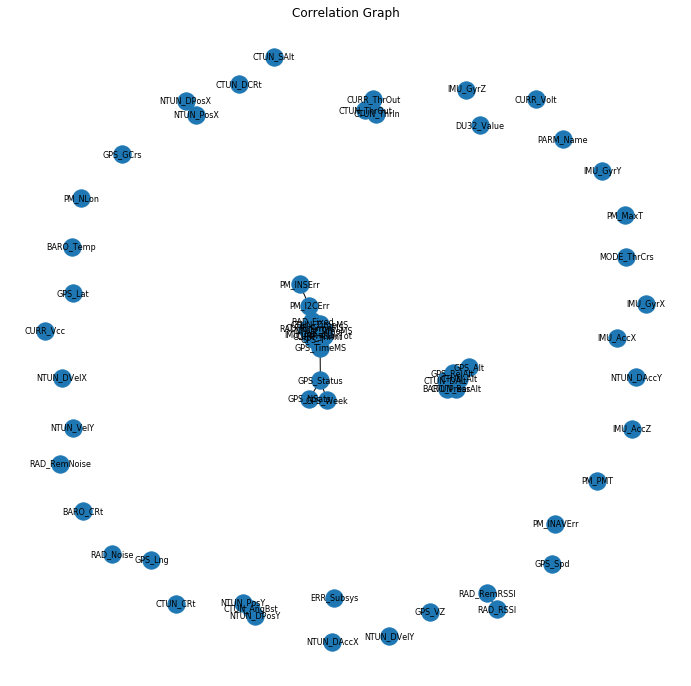

In [59]:
graph_generator(dt)

In [65]:
df.head()

,name,count
0,FMT_Format,2588
1,FMT_Type,2588
2,FMT_Name,2588
3,FMT_Length,2588
4,MODE_Mode,2541


In [69]:
d.columns 

Index(['DU32_Value', 'PARM_Name', 'ERR_Subsys'], dtype='object')

In [71]:
t = ['PARM_Name','ERR_Subsys']

In [ ]:
for v in t:
    if not v in d.co
    lumns
        t.remove()

['PARM_Name', 'ERR_Subsys']